# 재무제표 이용한 종목추천 모델링

In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and visualization
import seaborn as sns

# set grid
sns.set_style("whitegrid")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 주가 수집
pd.options.display.float_format = '{:.2f}'.format
from pykrx import stock
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import datetime as dt
import exchange_calendars as ecals

# MODELING
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# GBM
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV

# XGBoost
from xgboost import plot_importance
from xgboost import XGBClassifier
import sklearn.metrics as metrics

# SVM
from sklearn.svm import SVC

# 데이터 전처리

### 상장기업

2021년 3월 재무제표와 6월 제무제표 데이터 가공

In [2]:
df1 = pd.read_csv('C:/Users/USER/Desktop/Daseul/금융아이디어공모전/3월 재무.csv',skiprows=12, encoding='cp949')
df2 = pd.read_csv('C:/Users/USER/Desktop/Daseul/금융아이디어공모전/6월 재무.csv',skiprows=12, encoding='cp949')

In [3]:
df1.shape

(2268, 53)

In [4]:
df2.shape

(2344, 53)

In [5]:
df1 = df1.replace(',', '', regex=True)
df2 = df2.replace(',', '', regex=True)

In [6]:
'''
영업이익증가율(QoQ)              object
세전계속사업이익증가율(QoQ)          object
순이익증가율(지배, QoQ)           object
EBITDA증가율(QoQ)            object
EPS증가율(QoQ)               object
'''
lst = df1[['영업이익증가율(QoQ)','세전계속사업이익증가율(QoQ)','순이익증가율(지배, QoQ)','EBITDA증가율(QoQ)','EPS증가율(QoQ)']]
for col in lst:
    df1[col] = df1[col].str.replace(pat=r'[ㄱ-ㅣ가-힣]+', repl= r'', regex=True)
    df1[col] = df1[col].str.replace(pat=r'[^\w]', repl=r'', regex=True)
    df2[col] = df2[col].str.replace(pat=r'[ㄱ-ㅣ가-힣]+', repl= r'', regex=True)
    df2[col] = df2[col].str.replace(pat=r'[^\w]', repl=r'', regex=True)

In [7]:
df1 = df1.apply(pd.to_numeric, errors='ignore')
df2 = df2.apply(pd.to_numeric, errors='ignore')

In [8]:
df1.drop(['결산월'],inplace=True,axis=1)
df2.drop(['결산월'],inplace=True,axis=1)

In [9]:
length = 0
for col1 in df2['Name']:
    flag = True
    for col2 in df1['Name']:
        if col1 == col2:
            flag = False
    if flag:
        df2.drop(df2.index[length], inplace=True)
        continue
    length = length + 1
    if len(df1) == length:
        break
    

In [10]:
df2 = df2.reset_index().drop(['index'],axis=1)

In [11]:
# 두개의 데이터 프레임을 비율로 가공
df = df1.copy()
for col in df1.columns[2:51:]:
    for j in range(len(df1)):
        try:
            if df1[col][j] == 0:
                df[col][j] = np.nan
                continue
            df[col][j] = (df2[col][j] - df1[col][j]) / df1[col][j] * 100
        except:
            pass

In [12]:
df

,Code,Name,자산총계,유동자산,유형자산,부채총계,유동부채,자본총계,자본금,자본잉여금,...,총자산회전율,매출채권회전율,재고자산회전율,EV/EBITDA,"EPS(지배, 우선주제외, Adj.)","BPS(지배, 무형자산제외, Adj.)",EPS증가율(QoQ),"P/E(Adj., FY End)","P/B(Adj., FY End)",WICS업종코드(대)
0,A000020,동화약품,2.24,0.26,3.35,-0.07,-2.48,2.89,0.00,0.00,...,3.95,4.79,0.98,-4.54,14.87,2.26,-49.63,-4.54,7.56,G35
1,A000040,KR모터스,4.73,9.58,0.17,8.17,11.49,-2.58,0.00,-13.27,...,57.63,46.86,47.22,-82.09,26.67,-9.56,-57.71,-29.60,-2.93,G25
2,A000050,경방,0.62,9.74,-3.99,0.18,1.74,0.94,0.00,NaN,...,12.94,0.11,-6.79,0.14,52.21,1.89,4405.22,-28.88,4.35,G25
3,A000060,메리츠화재,2.96,NaN,-0.04,2.72,NaN,5.39,0.00,0.00,...,-3.81,-2.68,NaN,-12.12,24.77,5.82,61.98,-15.49,0.00,G40
4,A000070,삼양홀딩스,3.11,4.43,0.13,2.20,9.66,3.86,0.00,-0.26,...,7.80,1.78,1.17,-5.42,-6.05,6.88,-93.60,25.45,13.33,G30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,A950180,SNK,-2.41,-2.21,-12.28,-7.13,-5.79,-1.86,-4.86,-4.86,...,27.24,18.85,45.95,-89.37,-794.59,-1.62,851.69,-113.72,-3.21,G50
2264,A950190,미투젠,6.44,1.33,19.13,19.60,19.82,5.42,3.97,NaN,...,-4.39,NaN,NaN,-11.50,-8.64,4.48,689.91,1.54,-11.18,G50
2265,A950200,소마젠,-2.47,-2.51,-5.45,-3.09,-2.80,-2.21,-0.31,-0.31,...,23.43,11.95,-0.76,-325.45,-56.04,-2.81,45.59,147.16,11.72,G35
2266,A950210,프레스티지바이오파마,0.82,-1.57,23.47,15.75,30.75,0.16,-0.28,NaN,...,NaN,NaN,NaN,-566.40,-120.23,-0.63,NaN,-684.33,16.95,G35


주가 데이터 가공

In [13]:
df_n = df['Name']
df_c = df['Code']

In [14]:
h= []
for i in range(0,len(df_c)):
    df_new_c = df_c[i].lstrip("A")
    h.append(df_new_c)

In [15]:
# 기준점 잡기, 후에 삭제 예정
b = h[0]
n = df_n[0]

df8_start = stock.get_market_ohlcv_by_date('2021-09-01','2021-09-01',b)
df8_start['회사명'] = n

df8_finish = stock.get_market_ohlcv_by_date('2021-09-30','2021-09-30',b)
df8_finish['회사명'] = n

df10_finish = stock.get_market_ohlcv_by_date('2021-11-30','2021-11-30',b)
df10_finish['회사명'] = n


In [16]:
# 9월 1일 주가 수집
for i in range(0,len(h)):
    c = h[i]
    n = df_n[i]
    
    data = stock.get_market_ohlcv_by_date('2021-09-01','2021-09-01',c)
    data['회사명'] = n
    df8_start = pd.concat([df8_start, data], axis=0)
    

In [17]:
# 9월 30일 주가 수집
for i in range(0,len(h)):
    c = h[i]
    n = df_n[i]
    
    data = stock.get_market_ohlcv_by_date('2021-09-30','2021-09-30',c)
    data['회사명'] = n
    df8_finish = pd.concat([df8_finish, data], axis=0)

In [18]:
# 11월 30일 주가 수집
for i in range(0,len(h)):
    c = h[i]
    n = df_n[i]
    
    data = stock.get_market_ohlcv_by_date('2021-11-30','2021-11-30',c)
    data['회사명'] = n
    df10_finish = pd.concat([df10_finish, data], axis=0)

In [19]:
df8_start = df8_start[1:]
df8_start = df8_start.reset_index()

df8_finish = df8_finish[1:]
df8_finish = df8_finish.reset_index()

df10_finish = df10_finish[1:]
df10_finish = df10_finish.reset_index()

In [20]:
# 데이터 프레임을 주가 비율로 가공
stock_ratio1 = []
stock_ratio2 = []

com_name1 = []
com_name2 = []

for i in range(0,len(df8_start)):
    for j in range(0,len(df8_finish)):
        if df8_start['회사명'][i] == df8_finish['회사명'][j]:
            result= ((df8_finish['종가'][j] - df8_start['종가'][i])/df8_start['종가'][i])*100
            
            stock_ratio1.append(result)
            com_name1.append(df8_start['회사명'][i])
            
    for k in range(0, len(df10_finish)):
        if df8_start['회사명'][i] == df10_finish['회사명'][k]:
            result= ((df10_finish['종가'][k] - df8_start['종가'][i])/df8_start['종가'][i])*100
            
            stock_ratio2.append(result)
            com_name2.append(df8_start['회사명'][i])

In [21]:
stock_series1 = pd.DataFrame(stock_ratio1,columns=['종가비율'])
com_series1 = pd.DataFrame(com_name1,columns=['회사명'])

stock_series2 = pd.DataFrame(stock_ratio2,columns=['종가비율'])
com_series2 = pd.DataFrame(com_name2,columns=['회사명'])

In [22]:
target1 = pd.concat([stock_series1,com_series1], axis=1)
target2 = pd.concat([stock_series2,com_series2], axis=1)

재무제표 데이터와 주가 데이터 결합

In [23]:
month1 = df.copy()
month3 = df.copy()
month1['주가'] = 0.0
month3['주가'] = 0.0

In [24]:
for i in range(len(month1)):
    for j in range(len(target1)):
        if month1['Name'][i] == target1['회사명'][j]:
            month1['주가'][i] = target1['종가비율'][j]

    for k in range(len(target2)):
        if month3['Name'][i] == target2['회사명'][k]:
            month3['주가'][i] = target2['종가비율'][k]


In [25]:
month1 = month1[month1['주가'] != 0]
month3 = month3[month3['주가'] != 0]

month1 = month1.reset_index().drop(['index'],axis=1)
month3 = month3.reset_index().drop(['index'],axis=1)

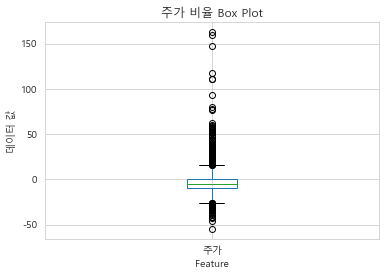

In [26]:
# 한달간 주가 변동률 BoxPlot
month1['주가'].plot.box()
plt.title("주가 비율 Box Plot")
plt.xlabel("Feature")
plt.ylabel("데이터 값")
plt.show()

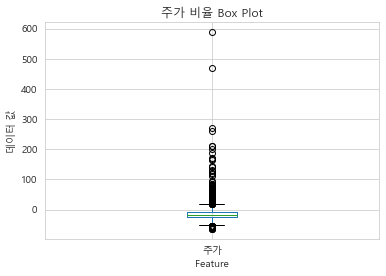

In [27]:
# 세달간 주가 변동률 BoxPlot
month3['주가'].plot.box()
plt.title("주가 비율 Box Plot")
plt.xlabel("Feature")
plt.ylabel("데이터 값")
plt.show()

In [28]:
# 이상치 제거
def get_outlier(data, column): 
    global lower, upper    
    
    q25 = np.quantile(data[column], 0.25)
    q75 = np.quantile(data[column], 0.75)          
    
    iqr = q75 - q25    
     
    upper = q75 + iqr * 1.5          
    lower = q25 - iqr * 1.5          
    
    data1 = data[data[column] > upper]     
    data2 = data[data[column] < lower]  

In [29]:
# 한달
get_outlier(month1,'주가')
month1 = month1[(lower <= month1['주가']) & (month1['주가'] <= upper)]

In [30]:
# 세달
get_outlier(month3,'주가')
month3 = month3[(lower <= month3['주가']) & (month3['주가'] <= upper)]

In [31]:
month1 = month1.reset_index().drop(['index'],axis=1)
month3 = month3.reset_index().drop(['index'],axis=1)

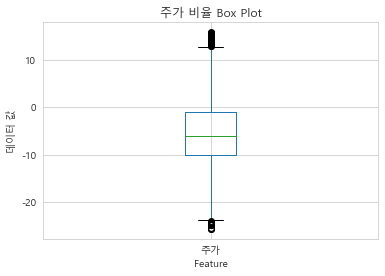

In [32]:
# 이상치 제거 후 한달 간 주가 변동률
month1['주가'].plot.box()
plt.title("주가 비율 Box Plot")
plt.xlabel("Feature")
plt.ylabel("데이터 값")
plt.show()

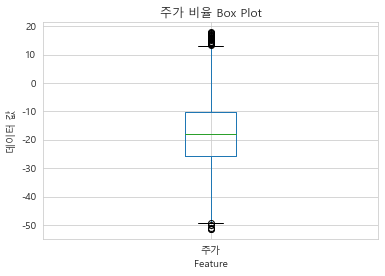

In [33]:
# 이상치 제거 후 세달 간 주가 변동률
month3['주가'].plot.box()
plt.title("주가 비율 Box Plot")
plt.xlabel("Feature")
plt.ylabel("데이터 값")
plt.show()

In [34]:
# 결측값 대체
month1 = month1.fillna(0)
month3 = month3.fillna(0)

In [35]:
model1 = month1.copy()
model2 = month3.copy()

In [36]:
# 주가 분류 (한달)
for i in range(len(model1)):
    if model1['주가'][i] < -15:
        model1['주가'][i] = 0
    elif model1['주가'][i] >= -15 and model1['주가'][i] < 0:
        model1['주가'][i] = 1
    elif model1['주가'][i] >= 0 and model1['주가'][i] < 15:
        model1['주가'][i] = 2
    else:
        model1['주가'][i] = 3    

In [37]:
# 주가 분류 (세달)
for i in range(len(model2)):
    if model2['주가'][i] < -15:
        model2['주가'][i] = 0
    elif model2['주가'][i] >= -15 and model2['주가'][i] < 0:
        model2['주가'][i] = 1
    elif model2['주가'][i] >= 0 and model2['주가'][i] < 15:
        model2['주가'][i] = 2
    else:
        model2['주가'][i] = 3    

In [38]:
# 한달 최종 데이터
model1

,Code,Name,자산총계,유동자산,유형자산,부채총계,유동부채,자본총계,자본금,자본잉여금,...,매출채권회전율,재고자산회전율,EV/EBITDA,"EPS(지배, 우선주제외, Adj.)","BPS(지배, 무형자산제외, Adj.)",EPS증가율(QoQ),"P/E(Adj., FY End)","P/B(Adj., FY End)",WICS업종코드(대),주가
0,A000040,KR모터스,4.73,9.58,0.17,8.17,11.49,-2.58,0.00,-13.27,...,46.86,47.22,-82.09,26.67,-9.56,-57.71,-29.60,-2.93,G25,1.00
1,A000050,경방,0.62,9.74,-3.99,0.18,1.74,0.94,0.00,0.00,...,0.11,-6.79,0.14,52.21,1.89,4405.22,-28.88,4.35,G25,2.00
2,A000060,메리츠화재,2.96,0.00,-0.04,2.72,0.00,5.39,0.00,0.00,...,-2.68,0.00,-12.12,24.77,5.82,61.98,-15.49,0.00,G40,2.00
3,A000070,삼양홀딩스,3.11,4.43,0.13,2.20,9.66,3.86,0.00,-0.26,...,1.78,1.17,-5.42,-6.05,6.88,-93.60,25.45,13.33,G30,1.00
4,A000080,하이트진로,-11.55,-29.57,-0.41,-16.72,-22.17,2.25,0.00,0.00,...,8.94,0.31,39.48,-18.55,2.93,-94.01,25.63,0.00,G30,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,A950180,SNK,-2.41,-2.21,-12.28,-7.13,-5.79,-1.86,-4.86,-4.86,...,18.85,45.95,-89.37,-794.59,-1.62,851.69,-113.72,-3.21,G50,2.00
1996,A950190,미투젠,6.44,1.33,19.13,19.60,19.82,5.42,3.97,0.00,...,0.00,0.00,-11.50,-8.64,4.48,689.91,1.54,-11.18,G50,2.00
1997,A950200,소마젠,-2.47,-2.51,-5.45,-3.09,-2.80,-2.21,-0.31,-0.31,...,11.95,-0.76,-325.45,-56.04,-2.81,45.59,147.16,11.72,G35,1.00
1998,A950210,프레스티지바이오파마,0.82,-1.57,23.47,15.75,30.75,0.16,-0.28,0.00,...,0.00,0.00,-566.40,-120.23,-0.63,0.00,-684.33,16.95,G35,1.00


In [39]:
# 세달 최종 데이터
model2

,Code,Name,자산총계,유동자산,유형자산,부채총계,유동부채,자본총계,자본금,자본잉여금,...,매출채권회전율,재고자산회전율,EV/EBITDA,"EPS(지배, 우선주제외, Adj.)","BPS(지배, 무형자산제외, Adj.)",EPS증가율(QoQ),"P/E(Adj., FY End)","P/B(Adj., FY End)",WICS업종코드(대),주가
0,A000020,동화약품,2.24,0.26,3.35,-0.07,-2.48,2.89,0.00,0.00,...,4.79,0.98,-4.54,14.87,2.26,-49.63,-4.54,7.56,G35,2.00
1,A000040,KR모터스,4.73,9.58,0.17,8.17,11.49,-2.58,0.00,-13.27,...,46.86,47.22,-82.09,26.67,-9.56,-57.71,-29.60,-2.93,G25,0.00
2,A000050,경방,0.62,9.74,-3.99,0.18,1.74,0.94,0.00,0.00,...,0.11,-6.79,0.14,52.21,1.89,4405.22,-28.88,4.35,G25,1.00
3,A000060,메리츠화재,2.96,0.00,-0.04,2.72,0.00,5.39,0.00,0.00,...,-2.68,0.00,-12.12,24.77,5.82,61.98,-15.49,0.00,G40,2.00
4,A000070,삼양홀딩스,3.11,4.43,0.13,2.20,9.66,3.86,0.00,-0.26,...,1.78,1.17,-5.42,-6.05,6.88,-93.60,25.45,13.33,G30,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,A950180,SNK,-2.41,-2.21,-12.28,-7.13,-5.79,-1.86,-4.86,-4.86,...,18.85,45.95,-89.37,-794.59,-1.62,851.69,-113.72,-3.21,G50,1.00
2003,A950190,미투젠,6.44,1.33,19.13,19.60,19.82,5.42,3.97,0.00,...,0.00,0.00,-11.50,-8.64,4.48,689.91,1.54,-11.18,G50,2.00
2004,A950200,소마젠,-2.47,-2.51,-5.45,-3.09,-2.80,-2.21,-0.31,-0.31,...,11.95,-0.76,-325.45,-56.04,-2.81,45.59,147.16,11.72,G35,0.00
2005,A950210,프레스티지바이오파마,0.82,-1.57,23.47,15.75,30.75,0.16,-0.28,0.00,...,0.00,0.00,-566.40,-120.23,-0.63,0.00,-684.33,16.95,G35,0.00


--------------------------------------------------------------------------------------------------------------------------------------

### 신규상장기업

상장직전과 상장직후 재무제표 데이터 가공

In [40]:
df_b = pd.read_csv('C:/Users/USER/Desktop/Daseul/금융아이디어공모전/상장전-최종.csv',skiprows=12,encoding='cp949')
df_a = pd.read_csv('C:/Users/USER/Desktop/Daseul/금융아이디어공모전/상장후-최종.csv',skiprows=12,encoding='cp949')

In [41]:
df_b = df_b.replace(',', '', regex=True)
df_a = df_a.replace(',', '', regex=True)

In [42]:
df_b = df_b.apply(pd.to_numeric, errors='ignore')
df_a = df_a.apply(pd.to_numeric, errors='ignore')

In [43]:
df_b.drop(['결산월'],inplace=True,axis=1)
df_a.drop(['결산월'],inplace=True,axis=1)

In [44]:
length = 0
for col1 in df_a['Name']:
    flag = True
    for col2 in df_b['Name']:
        if col1 == col2:
            flag = False
    if flag:
        df_a.drop(df_a.index[length], inplace=True)
        continue
    length = length + 1
    if len(df_b) == length:
        break
    

In [45]:
df_a = df_a.reset_index().drop(['index'],axis=1)

In [46]:
df_new = df_b.copy()
for col in df_b.columns[3:51:]:
    for j in range(len(df_b)):
        try:
            if df_b[col][j] == 0:
                df_new[col][j] = np.nan
                continue
            df_new[col][j] = (df_a[col][j] - df_b[col][j]) / df_b[col][j] * 100
        except:
            pass

In [47]:
df_new

,Code,Name,상장일,자산총계,유동자산,유형자산,부채총계,유동부채,자본총계,자본금,...,이자보상배율,자본유보율,순부채비율,차입금의존도,총자산회전율,매출채권회전율,재고자산회전율,EV/EBITDA,"EPS(지배, 우선주제외, Adj.)",WICS업종코드(대)
0,A383310,에코프로에이치엔,20210528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G15
1,A383800,LX홀딩스,20210527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G20
2,A276730,제주맥주,20210526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G30
3,A363250,진시스템,20210526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G35
4,A361670,삼영에스앤씨,20210521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,A145210,다이나믹디자인,20150319,0.63,-9.11,-0.75,-7.02,-7.06,0.60,0.00,...,44.26,-0.02,-2.57,-0.26,9.17,2.74,12.94,-72.98,-97.67,G25
633,A189690,포시에스,20150211,NaN,8.75,-0.41,152.43,152.43,5.25,-0.00,...,NaN,6.12,-4.06,NaN,NaN,NaN,NaN,-104.51,-1984.62,G45
634,A213420,덕산네오룩스,20150206,-0.38,0.64,-1.67,-1.95,-14.64,-0.25,0.00,...,NaN,-0.38,-27.99,NaN,-20.10,-8.61,-11.69,-221.96,-171.43,G45
635,A213500,한솔제지,20150126,NaN,-2.55,3.56,-0.44,-14.47,9.02,0.00,...,-4.56,3.13,-7.26,-1.48,NaN,NaN,NaN,11.87,-26.74,G15


주가 데이터 가공

In [48]:
df_stock = pd.read_excel('C:/Users/USER/Desktop/Daseul/금융아이디어공모전/상장일-최종.xlsx')
df_all = df_stock.copy()

df_n = df_all['Name']
df_c = df_all['Code']
df_d = df_all['주가수집날짜']

In [49]:
h= []
for i in range(0,len(df_c)):
    df_new_c = df_c[i].lstrip("A")
    h.append(df_new_c)

In [50]:
hh = pd.DataFrame(h,columns=['code'])
df_all['수정코드']=hh

In [51]:
df_c = df_all['수정코드']

In [52]:
# 분기 마지막 달 +60일 주가 수집
df_d_ts = []

for i in range(len(df_d)):
    df_d2 = dt.datetime.strptime(df_d[i], '%Y-%m-%d')
    df_d2 = df_d2+ relativedelta(months=2)
    df_d_ts.append(df_d2)

In [53]:
# 토요일, 공휴일을 평일로 수정
XKRX = ecals.get_calendar("XKRX") # 한국 코드 

for i in range(len(df_d_ts)):
    while XKRX.is_session(df_d_ts[i]) == False:
        df_d_ts[i] = df_d_ts[i]+ relativedelta(days=1)

In [54]:
# 기준행, 추후 삭제 예정

a = df_d_ts[0]
b = df_c[0] 
c = df_n[0]
    
df_s_b = stock.get_market_ohlcv_by_date(a,a,b)
df_s_a = stock.get_market_ohlcv_by_date(a,a,b)

In [55]:
# 기업명 리스트
on = []
for i in range(len(h)):
    d = df_d_ts[i]
    c = df_c[i]
    n = df_n[i]
    
    data_before = stock.get_market_ohlcv_by_date(d,d,c)
    
    
    df_s_b = pd.concat([df_s_b, data_before], axis=0)
    
    on.append(n)

In [56]:
df_s_b = df_s_b[1:]
df_s_b = df_s_b.reset_index()
df_s_b['회사명'] = on

In [57]:
# 분기 마지막 달 +90일 주가 수집
df_d_ts2 = []

for i in range(len(df_d_ts)):
    df_d_2 = df_d_ts[i]+ relativedelta(months=1)
    df_d_ts2.append(df_d_2)

In [58]:
# 토요일, 공휴일을 평일로 수정

XKRX = ecals.get_calendar("XKRX") # 한국 코드 

for i in range(len(df_d_ts2)):
    while XKRX.is_session(df_d_ts2[i]) == False:
        df_d_ts2[i] = df_d_ts2[i]+ relativedelta(days=1)

In [59]:
on2 = []

for i in range(len(h)):
    d = df_d_ts2[i]
    c = df_c[i]
    n = df_n[i]
    
    data_after = stock.get_market_ohlcv_by_date(d,d,c)
    
    df_s_a = pd.concat([df_s_a, data_after], axis=0)
    
    on2.append(n)

In [60]:
df_s_a = df_s_a[1:]
df_s_a = df_s_a.reset_index()
df_s_a['회사명'] = on2

In [61]:
k = []
o = []
for i in range(0,len(df_s_b)):
    for j in range(0,len(df_s_a)):
        if df_s_b['회사명'][i] == df_s_a['회사명'][j]:
            result= ((df_s_a['종가'][j] - df_s_b['종가'][i])/df_s_b['종가'][i])*100
            
            k.append(result)
            o.append(df_s_b['회사명'][i])
            

In [62]:
kk = pd.DataFrame(k,columns=['종가비율'])
oo = pd.DataFrame(o,columns=['회사명'])
l = pd.concat([oo,kk], axis=1)
l

,회사명,종가비율
0,에코프로에이치엔,-17.43
1,LX홀딩스,-4.90
2,제주맥주,-5.74
3,진시스템,-10.33
4,삼영에스앤씨,-8.99
...,...,...
632,다이나믹디자인,1.62
633,포시에스,-17.28
634,덕산네오룩스,-4.68
635,한솔제지,-5.24


재무제표 데이터와 주가 데이터 결합

In [63]:
df_new['주가'] = 0.0

In [64]:
for i in range(len(df_new)):
    for j in range(len(l)):
        if df_new['Name'][i] == l['회사명'][j]:
            df_new['주가'][i] = l['종가비율'][j]

In [65]:
df_new_copy = df_new[df_new['주가'] != 0]
df_new_copy

,Code,Name,상장일,자산총계,유동자산,유형자산,부채총계,유동부채,자본총계,자본금,...,자본유보율,순부채비율,차입금의존도,총자산회전율,매출채권회전율,재고자산회전율,EV/EBITDA,"EPS(지배, 우선주제외, Adj.)",WICS업종코드(대),주가
0,A383310,에코프로에이치엔,20210528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G15,-17.43
1,A383800,LX홀딩스,20210527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G20,-4.90
2,A276730,제주맥주,20210526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G30,-5.74
3,A363250,진시스템,20210526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G35,-10.33
4,A361670,삼영에스앤씨,20210521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G45,-8.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,A145210,다이나믹디자인,20150319,0.63,-9.11,-0.75,-7.02,-7.06,0.60,0.00,...,-0.02,-2.57,-0.26,9.17,2.74,12.94,-72.98,-97.67,G25,1.62
633,A189690,포시에스,20150211,NaN,8.75,-0.41,152.43,152.43,5.25,-0.00,...,6.12,-4.06,NaN,NaN,NaN,NaN,-104.51,-1984.62,G45,-17.28
634,A213420,덕산네오룩스,20150206,-0.38,0.64,-1.67,-1.95,-14.64,-0.25,0.00,...,-0.38,-27.99,NaN,-20.10,-8.61,-11.69,-221.96,-171.43,G45,-4.68
635,A213500,한솔제지,20150126,NaN,-2.55,3.56,-0.44,-14.47,9.02,0.00,...,3.13,-7.26,-1.48,NaN,NaN,NaN,11.87,-26.74,G15,-5.24


In [66]:
# 결측값이 6개 이상인 행 제거
df_new_copy = df_new_copy[df_new_copy.isnull().sum(1) < 6]
df_new_fin = df_new_copy.reset_index().drop(['index'],axis=1)

In [67]:
# 주가 분류
for i in range(len(df_new_fin)):
    if df_new_fin['주가'][i] < -15:
        df_new_fin['주가'][i] = 0
    elif df_new_fin['주가'][i] >= -15 and df_new_fin['주가'][i] < 0:
        df_new_fin['주가'][i] = 1
    elif df_new_fin['주가'][i] >= 0 and df_new_fin['주가'][i] < 15:
        df_new_fin['주가'][i] = 2
    else:
        df_new_fin['주가'][i] = 3    

In [68]:
# 신규 상장 기업 최종 데이터
df_new_fin

,Code,Name,상장일,자산총계,유동자산,유형자산,부채총계,유동부채,자본총계,자본금,...,자본유보율,순부채비율,차입금의존도,총자산회전율,매출채권회전율,재고자산회전율,EV/EBITDA,"EPS(지배, 우선주제외, Adj.)",WICS업종코드(대),주가
0,A357230,에이치피오,20210514,71.40,147.09,10.39,-8.59,-10.58,91.17,17.65,...,86.72,104.91,-23.08,-30.79,-16.47,-0.53,NaN,-24.77,G30,1.00
1,A294570,쿠콘,20210428,41.26,62.46,1.81,0.03,1.42,88.85,21.94,...,71.26,-0.30,-80.60,-12.70,-8.47,NaN,NaN,5.84,G45,1.00
2,A333620,엔시스,20210401,-7.16,-12.60,33.59,-52.13,-53.47,6.05,1.48,...,4.61,-14.51,-90.09,-23.96,-2.70,-25.22,NaN,430.77,G45,3.00
3,A289220,자이언트스텝,20210324,1.90,-12.36,65.96,13.38,14.06,-1.34,0.93,...,-2.81,-17.86,2.21,-25.54,-15.98,-19.46,-354.70,219.05,G50,3.00
4,A361390,제노코,20210324,7.04,-8.55,297.00,11.34,7.30,4.46,0.00,...,4.59,-2.33,-52.88,10.90,40.89,47.89,-69.02,106.67,G20,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,A177350,베셀,20150619,8.10,10.34,0.28,-33.47,-31.69,68.07,49.41,...,14.15,-171.76,-60.18,-21.59,-37.64,-15.27,46.55,-40.24,G45,1.00
165,A138250,엔에스쇼핑,20150327,0.08,-0.02,3.99,-8.07,-7.98,5.63,0.00,...,6.01,0.33,0.00,0.15,NaN,18.45,-6.78,-11.73,G25,1.00
166,A145210,다이나믹디자인,20150319,0.63,-9.11,-0.75,-7.02,-7.06,0.60,0.00,...,-0.02,-2.57,-0.26,9.17,2.74,12.94,-72.98,-97.67,G25,2.00
167,A213420,덕산네오룩스,20150206,-0.38,0.64,-1.67,-1.95,-14.64,-0.25,0.00,...,-0.38,-27.99,NaN,-20.10,-8.61,-11.69,-221.96,-171.43,G45,1.00


# 데이터 모델링

### 상장 기업

#### <한 달>

In [69]:
# Train / Test Data 분류
model1 = model1.rename(columns = lambda x:re.sub('[^A-Za-z0-9가-힣]', '', x))
model2 = model2.rename(columns = lambda x:re.sub('[^A-Za-z0-9가-힣]', '', x))

X = model1.iloc[:,2:51:]
y = model1['주가']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

#### GBM

In [70]:
boosting_gbm_ensemble = GradientBoostingClassifier()

boosting_gbm_ensemble.fit(X_train, y_train)
y_pred = boosting_gbm_ensemble.predict(X_test)

print("Training Score: {:.3f}".format(boosting_gbm_ensemble.score(X_train, y_train)))
print("Test Score: {:.3f}".format(boosting_gbm_ensemble.score(X_test, y_test)))

Training Score: 0.863
Test Score: 0.680


#### XGBoost

In [71]:
xgb = XGBClassifier(num_class=7,learning_rate=0.1,max_depth=10,eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print("Training Score: {:.3f}".format(xgb.score(X_train, y_train)))
print("Test Score: {:.3f}".format(xgb.score(X_test, y_test)))

Training Score: 0.996
Test Score: 0.698


#### SVM

In [72]:
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print("Training Score:: {:.3f}".format(svm.score(X_train, y_train)))
print("Test Score: {:.3f}".format(svm.score(X_test, y_test)))

Training Score:: 0.697
Test Score: 0.700


#### Random Forest

In [73]:
forest = RandomForestClassifier(random_state = 0)
model=forest.fit(X_train, y_train)

print("Training Score: {:.3f}".format(forest.score(X_train, y_train)))
print("Test Score: {:.3f}".format(forest.score(X_test, y_test)))

Training Score: 0.996
Test Score: 0.698


In [74]:
# 랜덤포레스트 파라미터 튜닝

params = {
    'n_estimators': [100], #100개의 sub Dataset, Decision Tree
    'max_depth': [6, 8, 10, 12],
    'min_samples_leaf': [8, 12, 18],
    'min_samples_split': [8, 16, 20]
}

model = RandomForestClassifier(random_state=0, n_jobs=-1) 
grid_cv = GridSearchCV(model, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print("Best hyperparameter: ", grid_cv.best_params_)

Best hyperparameter:  {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}


In [75]:
# Best 예측 값
final_bagging_rf_ensemble = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_leaf=8, 
                                                   min_samples_split=8, random_state=0)

final_bagging_rf_ensemble.fit(X_train, y_train)
y_pred = final_bagging_rf_ensemble.predict(X_test)

print(f'Best accuracy score: {accuracy_score(y_test, y_pred):.3}')

Best accuracy score: 0.7


--------------------------------------------------------------------------------------------------------------------------------------

#### <세 달>

In [76]:
# Train / Test Data 분류
X = model2.iloc[:,2:51:]
y = model2['주가']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

#### GBM

In [77]:
boosting_gbm_ensemble = GradientBoostingClassifier()

boosting_gbm_ensemble.fit(X_train, y_train)
y_pred = boosting_gbm_ensemble.predict(X_test)

print("Training Score: {:.3f}".format(boosting_gbm_ensemble.score(X_train, y_train)))
print("Test Score: {:.3f}".format(boosting_gbm_ensemble.score(X_test, y_test)))

Training Score: 0.862
Test Score: 0.558


#### XGBoost

In [78]:
xgb = XGBClassifier(num_class=7,learning_rate=0.1,max_depth=10,eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print("Training Score: {:.3f}".format(xgb.score(X_train, y_train)))
print("Test Score: {:.3f}".format(xgb.score(X_test, y_test)))

Training Score: 0.995
Test Score: 0.570


#### SVM

In [79]:
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print("Training Score:: {:.3f}".format(svm.score(X_train, y_train)))
print("Test Score: {:.3f}".format(svm.score(X_test, y_test)))


Training Score:: 0.619
Test Score: 0.582


#### Random Forest

In [80]:
forest = RandomForestClassifier(random_state = 0)
model=forest.fit(X_train, y_train)

print("Training Score: {:.3f}".format(forest.score(X_train, y_train)))
print("Test Score: {:.3f}".format(forest.score(X_test, y_test)))

Training Score: 0.995
Test Score: 0.594


--------------------------------------------------------------------------------------------------------------------------------------

상장기업으로만 모델링 시 <br><br>
결론 : 재무제표로 인한 주가 변동 예측 주기는 한달이 더 정확하다는 것을 알 수 있음

--------------------------------------------------------------------------------------------------------------------------------------

### 신규상장 기업을 Test Data로

상장기업 데이터를 Train Data로 모델링 한 후, 신규상장기업 데이터를 Test Data로 모델링

In [81]:
# Train과 Test 독립변수 매칭
test_x_list = list(df_new_fin.columns)
test_x_list = test_x_list[3:-2]

train_x_list = list(model1.columns)
train_x_list = train_x_list[3:-2]

x_list = []
for i in range(len(train_x_list)):
    for j in range(len(test_x_list)):
        if train_x_list[i] == test_x_list[j]:
            x_list.append(test_x_list[j])

In [82]:
# Train / Test 데이터 분할
X_train = model1[x_list]
y_train = model1['주가']
X_test = df_new_fin[x_list]
X_test = X_test.fillna(0)
y_test = df_new_fin['주가']

#### GBM

In [83]:
boosting_gbm_ensemble = GradientBoostingClassifier()

boosting_gbm_ensemble.fit(X_train, y_train)
y_pred = boosting_gbm_ensemble.predict(X_test)

print("Training Score: {:.3f}".format(boosting_gbm_ensemble.score(X_train, y_train)))
print("Test Score: {:.3f}".format(boosting_gbm_ensemble.score(X_test, y_test)))#### XGBoost

Training Score: 0.813
Test Score: 0.385


#### XGBoost

In [84]:
xgb = XGBClassifier(num_class=7,learning_rate=0.1,max_depth=10,eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print("Training Score: {:.3f}".format(xgb.score(X_train, y_train)))
print("Test Score: {:.3f}".format(xgb.score(X_test, y_test)))

Training Score: 0.996
Test Score: 0.355


#### SVM

In [85]:
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print("Training Score:: {:.3f}".format(svm.score(X_train, y_train)))
print("Test Score: {:.3f}".format(svm.score(X_test, y_test)))


Training Score:: 0.700
Test Score: 0.391


#### Random Forest

In [86]:
forest = RandomForestClassifier(random_state = 0)
model=forest.fit(X_train, y_train)

print("Training Score: {:.3f}".format(forest.score(X_train, y_train)))
print("Test Score: {:.3f}".format(forest.score(X_test, y_test)))

Training Score: 0.996
Test Score: 0.379
